In [1]:
ls

coco_eval.py   drive/     __pycache__/  test_zip/   transforms.py  vision/
coco_utils.py  engine.py  sample_data/  train_zip/  utils.py


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
cd /content

/content


In [4]:
from zipfile import ZipFile 

# specifying the zip file name 
#file_name = "flicker8k-dataset.zip"
file_name ="/content/drive/MyDrive/fruit.zip"

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
  # printing all the contents of the zip file 
  zip.printdir() 

  # extracting all the files 
  print('Extracting all the files now...') 
  zip.extractall() 
print('Done!') 

File Name                                             Modified             Size
test_zip/test/apple_77.jpg                     2019-10-02 03:13:36        27297
test_zip/test/apple_77.xml                     2019-10-02 03:13:36         1455
test_zip/test/apple_78.jpg                     2019-10-02 03:13:38        27275
test_zip/test/apple_78.xml                     2019-10-02 03:13:38          553
test_zip/test/apple_79.jpg                     2019-10-02 03:13:38       432081
test_zip/test/apple_79.xml                     2019-10-02 03:13:38          551
test_zip/test/apple_80.jpg                     2019-10-02 03:13:38        24724
test_zip/test/apple_80.xml                     2019-10-02 03:13:38          556
test_zip/test/apple_81.jpg                     2019-10-02 03:13:38       178517
test_zip/test/apple_81.xml                     2019-10-02 03:13:38          559
test_zip/test/apple_82.jpg                     2019-10-02 03:13:38        32724
test_zip/test/apple_82.xml              

In [5]:
ls

coco_eval.py   drive/     __pycache__/  test_zip/   transforms.py  vision/
coco_utils.py  engine.py  sample_data/  train_zip/  utils.py


In [6]:
#import cv 

import os 

images=os.listdir("/content/train_zip/train")

i=0
for i in range(len(images)):
  if images[i][-4:]=='.jpg':
    print(images[i])
  #print(images[i])


  i+=1
  if i==40:
    break

orange_69.jpg
mixed_6.jpg
orange_64.jpg
banana_66.jpg
banana_57.jpg
banana_24.jpg
apple_14.jpg
banana_37.jpg
orange_23.jpg
orange_57.jpg
banana_58.jpg
banana_22.jpg
orange_5.jpg
apple_43.jpg
orange_76.jpg
orange_7.jpg
orange_41.jpg
orange_25.jpg
banana_14.jpg
mixed_4.jpg
mixed_2.jpg
orange_20.jpg
orange_54.jpg
apple_70.jpg


In [7]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git


!cp vision/references/detection/utils.py /content/
!cp vision/references/detection/transforms.py /content
!cp vision/references/detection/coco_eval.py /content
!cp vision/references/detection/engine.py /content
!cp vision/references/detection/coco_utils.py /content


fatal: destination path 'vision' already exists and is not an empty directory.


In [8]:

import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [9]:

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

In [10]:
# defining the files directory and testing directory
files_dir = '/content/train_zip/train'
test_dir = '/content/test_zip/test'


class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'apple','banana','orange']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)




In [11]:

# check dataset
dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  240 

(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'labels': tensor([2, 2, 2, 2]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


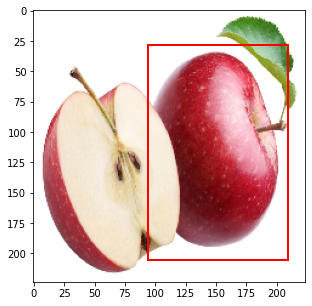

In [12]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

In [13]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [14]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [15]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


In [20]:
data=iter(data_loader)


In [22]:
#data=data.next()
#print(data)

In [23]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [25]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:01:41  lr: 0.000268  loss: 0.4019 (0.4019)  loss_classifier: 0.1557 (0.1557)  loss_box_reg: 0.2206 (0.2206)  loss_objectness: 0.0122 (0.0122)  loss_rpn_box_reg: 0.0134 (0.0134)  time: 5.0602  data: 0.7746  max mem: 8499
Epoch: [0]  [ 1/20]  eta: 0:01:27  lr: 0.000531  loss: 0.4019 (0.4060)  loss_classifier: 0.1470 (0.1514)  loss_box_reg: 0.2206 (0.2349)  loss_objectness: 0.0058 (0.0090)  loss_rpn_box_reg: 0.0080 (0.0107)  time: 4.5794  data: 0.4288  max mem: 8499
Epoch: [0]  [ 2/20]  eta: 0:01:19  lr: 0.000794  loss: 0.4019 (0.3754)  loss_classifier: 0.1470 (0.1370)  loss_box_reg: 0.2206 (0.2218)  loss_objectness: 0.0061 (0.0080)  loss_rpn_box_reg: 0.0080 (0.0086)  time: 4.4083  data: 0.2999  max mem: 8499
Epoch: [0]  [ 3/20]  eta: 0:01:13  lr: 0.001057  loss: 0.3970 (0.3808)  loss_classifier: 0.1387 (0.1375)  loss_box_reg: 0.2206 (0.2273)  loss_objectness: 0.0061 (0.0084)  loss_rpn_box_reg: 0.0050 (0.0077)  time: 4.3149  data: 0.2258  max mem: 8499
Epoch: [

In [26]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


In [27]:
#pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))


predicted #boxes:  10
real #boxes:  1


EXPECTED OUTPUT


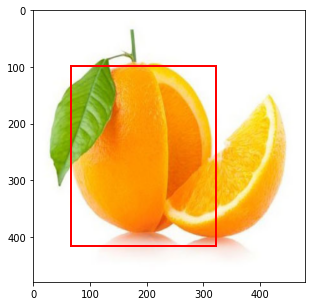

In [28]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


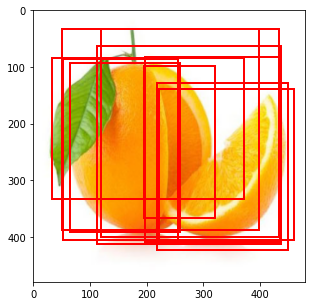

In [30]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)


NMS APPLIED MODEL OUTPUT


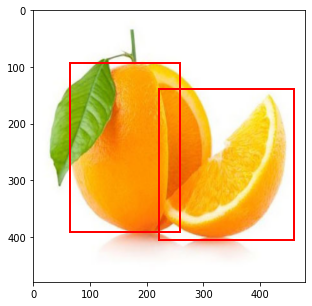

In [31]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)


EXPECTED OUTPUT



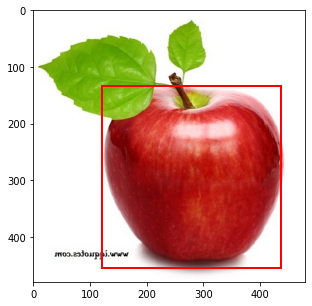

MODEL OUTPUT



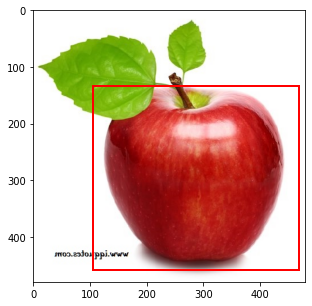

In [32]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)
